Created on Friday 15 January 2021

***Group 5 - Classification
Extraction features syntaxe ***

@author : Fallou BAH

This notebook creates new features on the input dataframe, analyzes its main components and then classifies the innovation and non-innovation items.

In [ ]:
!python3 -m spacy download fr_core_news_md
!pip install langdetect

     |████████████████████████████████| 88.6MB 1.3MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-cp36-none-any.whl size=90338490 sha256=13e483db6b894a20d8eb2ec5f68a9d0b19c5695a38eaad498e2051ec0a690eca
  Stored in directory: /tmp/pip-ephem-wheel-cache-wa48r3p8/wheels/c6/18/b6/f628642acc7872a53cf81269dd1c394d96da69564ccfac5425
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')
     |████████████████████████████████| 983kB 7.6MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=dcad54162d87299115cec1a9f89748aa66c6351c55b5ff02263f1a4ade00afcd
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


# Create link between drive and notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os 
os.chdir('/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/')

Mounted at /content/drive


# Import

In [ ]:
import pandas as pd 
import numpy as np
import re
from tqdm import tqdm 
from string import punctuation
import spacy
import fr_core_news_md
import warnings
from textblob import TextBlob
from langdetect import detect
import matplotlib.pyplot as plt


import nltk
from nltk.stem import  WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
warnings.filterwarnings('ignore')
scaler = StandardScaler()
nlp = fr_core_news_md.load()
stop_words_french = stopwords.words('french') 
stop_words_english = stopwords.words('english') 
lemmer=WordNetLemmatizer()

#  Data import

In [ ]:
data : pd.DataFrame = pd.read_json("Data.json")[['art_id','art_content','art_title']]
data = data [data['art_content'] !='']
data.head()

,art_id,art_content,art_title
1,1,La FNCDG et l’ANDCDG ont publié en septembre l...,9ème édition du Panorama de l’emploi territorial
2,2,Malgré la levée des mesures de confinement le ...,ACTUALITÉS FNCDG / COVID19
25,25,Quels étaient les objectifs poursuivis par le ...,"Interview de M. Olivier DUSSOPT, Secretaire d’..."
27,27,"La journée thématique, qui aura lieu durant le...",Journée Thématique FNCDG « Les services de san...
28,28,La 1ère journée thématique en région sur le th...,Journée Thématique FNCDG « Vers de nouveaux mo...


# Pre-processing

In [ ]:
# this function allows you to lemmatize English words

def lemmatization(word : str) -> str:
  """ Documentation
  parameters
    word : word to lemmatize
  Output
    word : lemmatized word
  """
  for pos in ['a', 's', 'r', 'n', 'v']:
    word=lemmer.lemmatize(word, pos)
  return word

In [ ]:
# This function allows you to clean up keywords

def clean_lexique(link_lexique : str) -> list:
  """ Documentation
    Parameter :
      link_lexique : link of keyword
    Output : 
      list_key_word : list of cleaned keywords 
  """
  df_lexique: pd.DataFrame = pd.read_csv(link_lexique, sep="  ", header=None)
  df_lexique.columns: list = ['lexique']
  list_lexique = df_lexique.lexique.values.tolist()
  list_lexique_net : list = []

  for k in list_lexique :
    k=k.lower()
    k=k.replace(" d'",' ')
    k=k.replace("."," ")
    k=k.replace("-"," ")
    k=k.replace("l'"," ")
    k=k.replace("/"," ")
    stop_word =[ 'le', 'par', 'les', 'du', 'la', 'de', "des"]

    k_ :list = []
    try :
      if detect(k)=='fr':
        k_npl=nlp(k)
        for j in k_npl:
          if j.lemma_ not in stop_word:
            k_.append(j.lemma_)
      elif detect(k)=='en' :
        for j in k.split():
          j = lemmatization(j)
          if j not in stop_word:
            k_.append(j)
      else :
        k_= k.split()
    except :
      k_ = k.split()

    list_lexique_net.append(' '.join(k_))

  list_lexique_net = pd.unique(list_lexique_net).tolist()
  return list_lexique_net

link_lexique = "/content/drive/MyDrive/G5 Inter-Promo 2021/Ressources/Lexique_Innovation.txt"
list_lexique = clean_lexique(link_lexique)

In [ ]:
# A function that cleans the contents

def clean(content:str)->str:
  """ Documentation
  Parameter :
      content : content of article
  Output :
      content : cleaned content 
  """
  lang = 'en'
  try :
    if detect(content) == 'fr':
      lang = 'fr'
  except :
    pass

  content=re.sub('\W+',' ',content)
  content=content.lower()

  for p in punctuation:
    content=content.replace(p," ")

  content_lemma=[]
  if lang == 'fr' :
    content_=nlp(content)
    for token in content_:
      if str(token) not in stop_words_french:
        content_lemma.append(token.lemma_)
  else :
    for token in content.split():
      if token not in stop_words_english :
        content_lemma.append(lemmatization(token))

  return ' '.join(content_lemma)

In [ ]:
# Counts the number of words
def count_words(text: str) -> int:
    """Documentation
      Parameters:
        text: text of the article
      Output:
        nb_word: number of word in  the text
    """
    # counts the number of words present in the text
    return len(text.split())

In [ ]:
# Count the number of time where the words in the list appear

def count_lexique(text : str) -> int:
    """ Documentation
    Parameters:
        text: text of the article

    Output:
        t : number of keyword in the text
    """
    t : int = 0
    m  : int = max([len(w.split()) for w in list_lexique])

    text = text.lower()
    text = text.split()
    n = len(text)
    for j in range(len(text)):
      word : str = ''
      for k in range(m):
        if j+k < n :
          word+=' '+text[j+k]
          if (word[1:] in list_lexique):   #list_lexique: List of word that we will check in the sentences
            t += 1
    return t

In [ ]:
# Count the number of sentence
def count_sentence( text : str) -> int:
    """Documentation
    Parameters:
        text: text of the article

    Out (if exists):
        n:  The number of sentence in a article
    """

    n : int = 0
   
    if not isinstance(text, str):
        text: str = str(text)

    if (text != None):
        text = text.replace("..", ".")
        text = text.replace("...", ".")
        text = text.replace("!", ".")
        text = text.replace("!!", ".")
        text = text.replace("!!!", ".")
        text = text.replace("?", ".")
        text = text.replace("??", ".")
        text = text.replace("???", ".")
        text = text.replace("?!", ".")
        text = text.replace("!?", ".")
        n = len(sent_tokenize(text))

    return n

In [ ]:
# This function allows you to create features

def create_features(data : pd.DataFrame) -> pd.DataFrame:
  ''' Documentation
    Parameters :
      data : Dataframe
    Output :
      data : Dataframe
  '''

  data ['clean_content'] = data['art_content'].apply(clean)
  data ['clean_title'] = data['art_title'].apply(clean)

  data["count_keywords_content"] : np.DataFrame = data['clean_content'].apply(count_lexique)
  data["count_keywords_title"] : np.DataFrame = data['clean_title'].apply( count_lexique)
  data["count_words_content"]: np.DataFrame = data['clean_content'].apply(count_words)
  data["count_words_title"]: np.DataFrame = data['clean_title'].apply(count_words)
  data["count_sentences"]: np.DataFrame = data['art_content'].apply(count_sentence)

  data['ratio_keywords_content']: np.DataFrame  = data['count_keywords_content'] / data['count_words_content']
  data['ratio_keywords_content']: np.DataFrame  = data['ratio_keywords_content'].fillna(0)

  data['ratio_keywords_sentence']: np.DataFrame  = data['count_keywords_content'] / data['count_sentences']
  data['ratio_keywords_sentence']: np.DataFrame  = data['ratio_keywords_sentence'].fillna(0)

  data['ratio_keywords_title']: np.DataFrame  = data['count_keywords_title'] / data['count_words_title']
  data['ratio_keywords_title']: np.DataFrame  = data['ratio_keywords_title'].fillna(0)
  
  return data

In [ ]:
%%time 
data_feat = create_features(data)

CPU times: user 33min 14s, sys: 23.5 s, total: 33min 38s
Wall time: 33min 41s


In [ ]:
#If you execute the codes, I advise you to save this "data_feat" dataframe 
# that you can reuse in my notebooks with the mention "innovation". 
#You can see that the execution time is about 35 minutes.

# Dimensional reduction

In [ ]:
data = data_feat [['count_keywords_content', 'ratio_keywords_content', 'count_keywords_title', 'ratio_keywords_title','ratio_keywords_sentence']]
data.index = data_feat.art_id
data.head()

,count_keywords_content,ratio_keywords_content,count_keywords_title,ratio_keywords_title,ratio_keywords_sentence
art_id,,,,,
1,0,0.000000,0,0.000000,0.000000
2,2,0.022222,0,0.000000,0.500000
25,6,0.007823,0,0.000000,0.111111
27,2,0.025974,1,0.142857,0.666667
28,0,0.000000,0,0.000000,0.000000


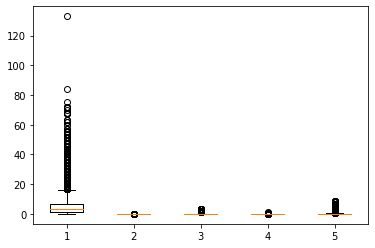

In [ ]:
plt.boxplot(data.values)
plt.show()

In [ ]:
data.describe()

,count_keywords_content,ratio_keywords_content,count_keywords_title,ratio_keywords_title,ratio_keywords_sentence
count,11608.000000,11608.000000,11608.000000,11608.000000,11608.000000
mean,5.475965,0.010668,0.143866,0.020992,0.207241
std,7.847404,0.014080,0.398989,0.064137,0.411607
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.001432,0.000000,0.000000,0.024317
50%,3.000000,0.006536,0.000000,0.000000,0.106250
75%,7.000000,0.014400,0.000000,0.000000,0.250000
max,133.000000,0.250000,3.000000,1.000000,9.000000


In [ ]:
# Centre and reduce
data_scale = scaler.fit_transform(data)

In [ ]:
# The sum of the quantities of variance explained for the first 3 principals components

pca = PCA(n_components=3)
Xp = pca.fit_transform(data_scale)

pca.explained_variance_ratio_.sum()

0.9062644008320964

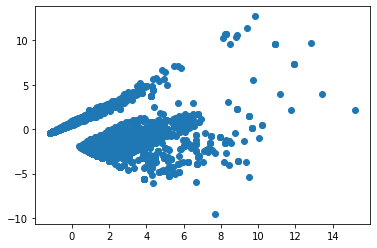

In [ ]:
# Display on the first 2 axes
plt.scatter(Xp[:,0],Xp[:,1])
plt.show()

In [ ]:
# This function is used to calculate the steering coefficient and 
# the y-intercept at the origin of a straight line passing through 
# the 2 points passed as a parameter.

def slope_intercept(A : list, B : list) -> tuple:
  """
  Parameters : 
      A : point 1
      B : point 2
  Output :
      a : slope
      b : intercept
  """
  a = ( B[1] - A[1] ) / ( B[0] - A[0] )
  b = A[1] - a * A[0]
  return a,b

# This function calculates the difference between the Y-axis of 
# the point and its Y-axis corresponds to the line
def classification_group(C : list, A: list, B :list) -> float:
  """
  Parameters :
      A,B,C : points
  Output :
  """
  a,b = slope_intercept(A, B)
  return C[1]-a*C[0]-b

100%|██████████| 11608/11608 [00:00<00:00, 334909.58it/s]


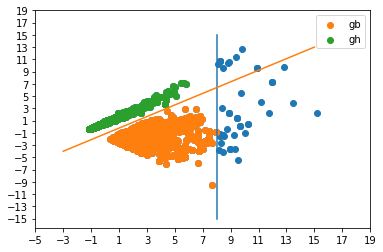

In [ ]:
index_group_bottom : list = []
gb : list = []
index_group_top : list = []
gh : list = []
art_id : list = data.index.values.tolist()
A1 :list = [8, 15]
B1 :list = [8, -15]
A2 :list = [-3, -4]
B2 :list = [ 15, 13]

for i in tqdm(range(Xp.shape[0])) :
  if Xp[i,0]< A1[0] :
    if classification_group(Xp[i,:], A2, B2) >0 :
      index_group_top.append(art_id[i])
      gh.append(i)
    else :
      index_group_bottom.append(art_id[i])
      gb.append(i)   


plt.scatter(Xp[:,0],Xp[:,1])
plt.scatter(Xp[gb,0],Xp[gb,1], label='gb')
plt.scatter(Xp[gh,0],Xp[gh,1], label='gh')
plt.plot([A1[0], A1[0]],[A1[1],B1[1]])
plt.plot([A2[0], B2[0]], [A2[1], B2[1]])

plt.xticks(range(-5, 21, 2))
plt.yticks(range(-15, 21, 2))
plt.legend()
plt.show()

# Prediction

In [ ]:
# We retrieve the id's of items that we are sure are non-innovative.
dff = data[data['count_keywords_content']==0]
dff = dff[dff['count_keywords_title']==0]
art_ids = dff.index.values.tolist()

len(art_ids)

2604

In [ ]:
# Determine which group its non-innovative products belong to 

print("The percentage of articles in common of the non-innovative articles \nand that of the group in orange :", 100*len(set(art_ids).intersection(set(index_group_bottom)))/len(art_ids),"%")
print("The percentage of articles in common of the non-innovative articles \nand that of the group in vert :", 100*len(set(art_ids).intersection(set(index_group_top)))/len(art_ids),"%")

The percentage of articles in common of the non-innovative articles 
and that of the group in orange : 0.0 %
The percentage of articles in common of the non-innovative articles 
and that of the group in vert : 100.0 %


In [ ]:
data_scale = pd.DataFrame(data_scale, columns=data.columns, index = data.index)

data_scale['label'] = -1 # unknown
data_scale.loc[index_group_bottom,'label'] = 1 # innovation
data_scale.loc[index_group_top,'label'] = 0 # No Innovation

In [ ]:
train = data_scale[data_scale['label']!=-1]
X = train.drop('label', axis= 1)
y = train.label.values 

In [ ]:
# this function allows you to train a model either by cross validation 
# and display its accuracy and f1_score or by simple training 
# and display its accuracy and f1_score and also its confusion matrix if you wish.

def training(model, if_plot : bool = False, if_val_cross : bool = False) :
  """
  Parameters :
    model : model
    if_plot : if you want to display your confusion matrix
    if_val_cross : if you want to train by cross-validation
    Output :
  """
  if if_val_cross :
    print("accuracy ...")
    print(cross_val_score(model, X, y, cv=5))

    print("f1_score ...")
    print(cross_val_score(model, X, y, cv=5, scoring='f1'))

  else :

    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_val)

    print("accuracy ...")
    print(model.score(X_val, Y_val))
    print("f1_score ...")
    print(f1_score(Y_val, y_pred))

    if if_plot:
      plot_confusion_matrix(model, X_val, Y_val, cmap='Blues', normalize=None,
                      display_labels=['No innovation', 'Innovation']);

logit
accuracy ...
1.0
f1_score ...
1.0
----------------------------------------------------
rf
accuracy ...
1.0
f1_score ...
1.0
----------------------------------------------------


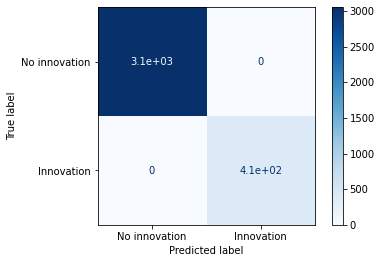

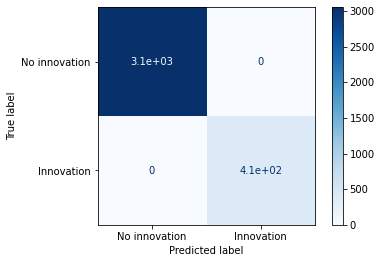

In [ ]:
models = {
    'logit' : LogisticRegression(),
    'rf' : RandomForestClassifier()
}

for model in models.keys():
  print(model)
  training(models[model], True)
  print('----------------------------------------------------')

In [ ]:
for model in models.keys():
  print(model)
  training(models[model], False, True)
  print('----------------------------------------------------')

logit
accuracy ...
[1. 1. 1. 1. 1.]
f1_score ...
[1. 1. 1. 1. 1.]
----------------------------------------------------
rf
accuracy ...
[1. 1. 1. 1. 1.]
f1_score ...
[1. 1. 1. 1. 1.]
----------------------------------------------------


In [ ]:
# Here, we are on the labeling made is correct.

In [ ]:
test = data_scale [data_scale['label']==-1]
X_test = test.drop('label', axis=1)

In [ ]:
# Regression logistic

model = LogisticRegression()
model.fit(X,y)
y_pred_rl= model.predict(X_test)

In [ ]:
# Random forest

model = RandomForestClassifier()
model.fit(X,y)
X_test = test.drop('label', axis=1)
y_pred_rf= model.predict(X_test)

In [ ]:
# Make sure that 2 models predict the same labels.
print('f1_score : ', f1_score(y_pred_rf, y_pred_rl))

z=y_pred_rf-y_pred_rl
print('accuracy :', len(z[z==0])/len(z))

f1_score :  1.0
accuracy : 1.0


# Evaluation

In [ ]:
df_pred = pd.DataFrame( y_pred_rf, columns=['label_innovation'], index = test.index)
df_pred.head()

,label_innovation
art_id,
850,1
1046,1
1202,0
1330,1
1357,0


In [ ]:
label=train[['label']]
label.rename(
    columns={'label':'label_innovation' },
    inplace=True
)

In [ ]:
label=label.append(df_pred)
label.sort_index(inplace=True)
label.head()

,label_innovation
art_id,
1,0
2,0
25,0
27,1
28,0


In [ ]:
# Ensuring that the labelling is accurate  
y = label.label_innovation
X = data_scale.drop('label', axis=1)

logit
accuracy ...
1.0
f1_score ...
1.0
----------------------------------------------------
rf
accuracy ...
1.0
f1_score ...
1.0
----------------------------------------------------


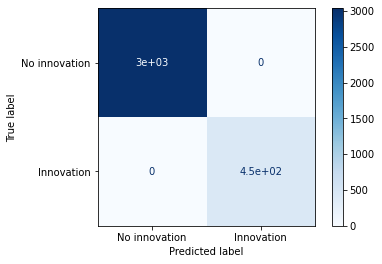

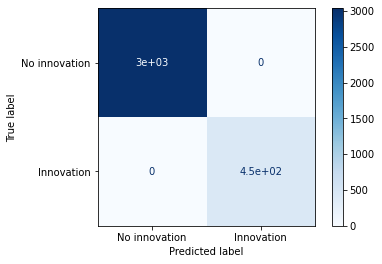

In [ ]:
for model in models.keys():
  print(model)
  training(models[model], True)
  print('----------------------------------------------------')

In [ ]:
for model in models.keys():
  print(model)
  training(models[model], False, True)
  print('----------------------------------------------------')

logit
accuracy ...
[1. 1. 1. 1. 1.]
f1_score ...
[1. 1. 1. 1. 1.]
----------------------------------------------------
rf
accuracy ...
[1. 1. 1. 1. 1.]
f1_score ...
[1. 1. 1. 1. 1.]
----------------------------------------------------


# Labelling

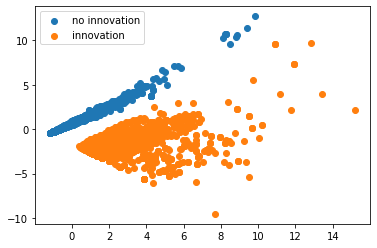

In [ ]:
# Overview of innovative and non-innovative articles
index_no_innovation = np.where(y==0)[0].tolist()
index_innovation = np.where(y==1)[0].tolist()

plt.scatter(Xp[index_no_innovation,0],Xp[index_no_innovation,1], label='no innovation')
plt.scatter(Xp[index_innovation,0],Xp[index_innovation,1], label='innovation')
plt.legend()

In [ ]:
print('The number of innovative items :',len(y[y==1]))

The number of innovative items : 1475


In [ ]:
print('the number of no innovative items :',len(y[y==0]))

the number of no innovative items : 10133


In [ ]:
label.head()

,label_innovation
art_id,
1,0
2,0
25,0
27,1
28,0


In [ ]:
label.to_csv("label_innovation_v1.csv", index=True)